[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb)

# Beispiel 1:
## Deutschland vom 10.03.2020 bis 16.04.2020

Initial definieren wir wie viele Threads wir bei dem MCMC-Sampling gleichzeitig rechnen lassen wollen (`%env OMP_NUM_Thread`). Zudem soll das `covid19_inference`-Modul installiert werden. Ferner stellen wir mit `%load_ext autoreload` und `%autoreload 2` sicher, dass automatisch die Module vor der Ausführung des Codes nachgeladen werden. Das kann insbesondere dann hilfreich sein, wenn wir Änderungen durchführen, den Kernel aber nicht neustarten wollen. Zusätzlich wird das `pytensor`-Modul geladen sowie das `pymc`. Vor allem `pymc` spielt in der Bayes'schen Inferenz eine wichtige Rolle.

In [2]:
# use 1 thread per chain
%env OMP_NUM_THREADS=1

!pip install covid19_inference
%load_ext autoreload
%autoreload 2
import pytensor
#pytensor.config.mode = "NUMBA"
import pymc as pm

env: OMP_NUM_THREADS=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




# Beispiel für Deutschland
Hier verwenden wir JHU-Daten.


An dieser Stelle werden zunächst die Voraussetzungen geladen. Diese sollten zuvor installiert worden sein, damit wir diese auch importieren können.


In [3]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytensor.tensor as at
import pymc as pm
import timeit

Nun importieren wir das installierte Modul `covid19_inference`

In [4]:

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Datengenerierung

Als nächstes wir das Datenset geladen bzw. heruntergeladen. Es gibt insgesamt viele möglichen Download-Ressourcen, jedoch verwenden wir in diesem Fall den von der John Hopkins Universität.
[Github-Repository Link für die csv-Datei](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)


In [5]:
jhu = (
    cov19.data_retrieval.JHU()
)
jhu.download_all_available_data(force_download=False)

Wir können auf die Daten nun mithilfe von jhu.daten zugreifen.

Wir erstellen erstmal einen intialen Zeitraum vom 10.03.2020 bis zum 16.04.2020


In [6]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime(2020, 4, 16)

Hier werden die totalen Fallzahlen bzw. neu gemeldeten Fallzahlen aus dem Datensatz gefiltert. Wir geben dabei den Üebrgabeparameter `country="Germany"` an, da wir die Datenanalyse für Deutschland durchführen wollen.

In [7]:
total_cases_obs = jhu.get_total(
    country="Germany", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    country="Germany", data_begin=bd, data_end=ed
)



## Modellerstellung
Um das Modell zu erstellen, werden zunächst einige Parameter gesetzt.


*   diff_data_sim
*   num_days_forecast




In [8]:
diff_data_sim = 16
num_days_forecast = 10

*   `prior_date_mild_dist_begin`: Wir setzen einen Zeitpunkt fest für den Beginn der ersten politischen Maßnahme
*   `prior_date_strong_dist_begin`: Wir setzen einen Zeitpunkt für die nächste politische Maßnahme
*   `prior_date_contact_ban_begin`: Wir setzen einen Zeitpunkt für das Einsetzen der ersten Kontaktsperre

In [9]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)


*   `change_points`: Ein Dictionary, das jeweils Einträge für die 3 politischen Maßnahmen enthält. Dazu werden jeweils Parameter gesetzt, wie der Prior für die Ansteckungsrate λ
*   pr_mean_date_transient
*   pr_sigma_date_transient
*   pr_median_lambda
*   pr_sigma_lambda

In [10]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

*  `params_model:` Ein Dictionary, das verschiedene Parameter enthält. Zum Einen die neu gemeldeten Fallzahlen, aber auch die Länge der Vorhersage sowie die Anzahl der Population
*   `pr_delay`: Hier wollen wir den Prior setzen für den Parameter der Meldeverzögerung


In [11]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

Mit dem zuvor definieren params_model wollen wir nun ein sogenanntes Cov19-Modell erstellen. Dazu initialiseren wir dieses Objekt mit einem Array für die zeitabhängige Infektionsrate λ (`lambda_t_log`). Ferner setzen wir die Priori-Verteilung der Genesungsrate μ. Zudem wird auch `I_begin` durch einen Prior bestimmt.
Um das SIR-Modell zu erstellen benötigt es dann die zeitabhängige Infektionsrate (`lambda_t_log`), die Genesungsrate μ und `I_begin`. Wir speichern das SIR-Modell in der Variablen `new_cases`. Diese wird dann verändert mit der `delay`-Funktion, in der wir die Meldungen um einen lognormal Verzögerungswert verändern. Als letztes wird noch der Wochenendeffekt betrachtet. Hier wird die Funktion `week_modulation` auf das SIR-Modell angewandt.
Zuletzt wird noch die `student_t_likelihoo`d-Funktion auf das SIR-Modell angewandt.


In [12]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    I_begin = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        I_begin=I_begin,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        delay_kernel="lognormal",
        median_delay_kwargs={
            "name": "delay",
            "mu": pr_delay,
            "sigma": 0.2,
        },
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        week_modulation_type="step",
        weekend_factor_kwargs={
            "name": "weekend_factor",
            "mu": np.log(0.3),
            "sigma": 0.5,
        },
        weekend_days=(6, 7),
    )
    pm.Deterministic("new_cases", new_cases)

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


## MCMC sampling

Wir haben nun das Modell gebaut. Jetzt können wir den MCMC-Algorithmus anwenden, um uns Samples für die Verteilungen und den zugrundeliegenden Parameter zu generieren.

An dieser Stelle sei bereits auf Optimierungseigenschaften hingewiesen, um die Genauigkeit bzw. Performance zu verändern.




In [13]:
start_time = timeit.default_timer()
idata = pm.sample(model=this_model, tune=50, draws=100, init="advi+adapt_diag")
elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt.")

Die Samples wurden in 492.88690024799996 Sekunden hinzugefügt.



## Plotting
Wir wollen uns die A-Priori-Verteilungen der Parameter ansehen.

### Distributions


['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_raw_', 'transient_len_2_raw_', 'transient_len_3_raw_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'sigma_obs']


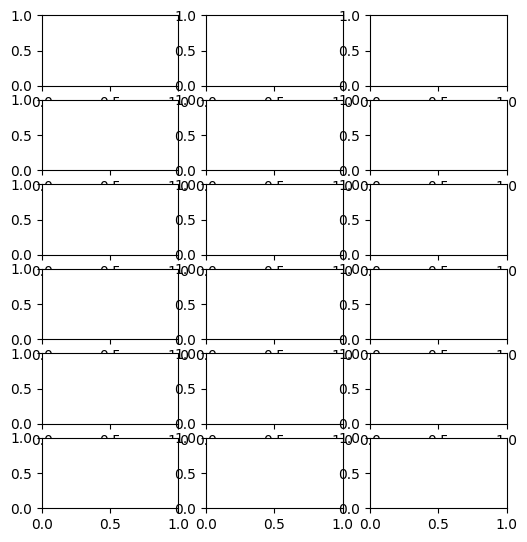

In [14]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

varnames = this_model.untransformed_freeRVs
print(varnames)


An dieser Stelle werden die Plots jeweils gefüllt.

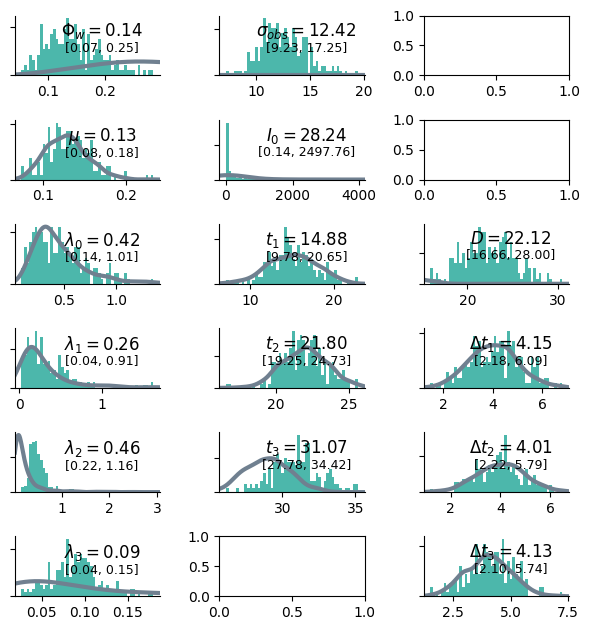

In [15]:
# Plot them
for i, (key, math) in enumerate(
    # left column
    zip(
        ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"],
        ["\Phi_w", "\mu", "\lambda_0", "\lambda_1", "\lambda_2", "\lambda_3"],
    )
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 0], dist_math=math)

for i, (key, math) in enumerate(
    # mid column
    zip(
        [
            "sigma_obs",
            "I_begin",
            "transient_day_1",
            "transient_day_2",
            "transient_day_3",
        ],
        [
            "\sigma_{obs}",
            "I_0",
            "t_1",
            "t_2",
            "t_3",
        ],
    )
):
    cov19.plot.distribution(
        this_model,
        idata,
        key,
        ax=axes[i, 1],
        dist_math=math,
    )

for i, (key, math) in enumerate(
    # right column
    zip(
        [
            "delay",
            "transient_len_1",
            "transient_len_2",
            "transient_len_3",
        ],
        ["D", "\Delta t_1", "\Delta t_2", "\Delta t_3"],
    )
):
    cov19.plot.distribution(
        this_model,
        idata,
        key,
        ax=axes[i + 2, 2],
        dist_math=math,
    )

fig.tight_layout()
fig  # To print in jupyter notebook


### Timeseries
Wir können uns auch eine Timeseries ausgeben lassen.


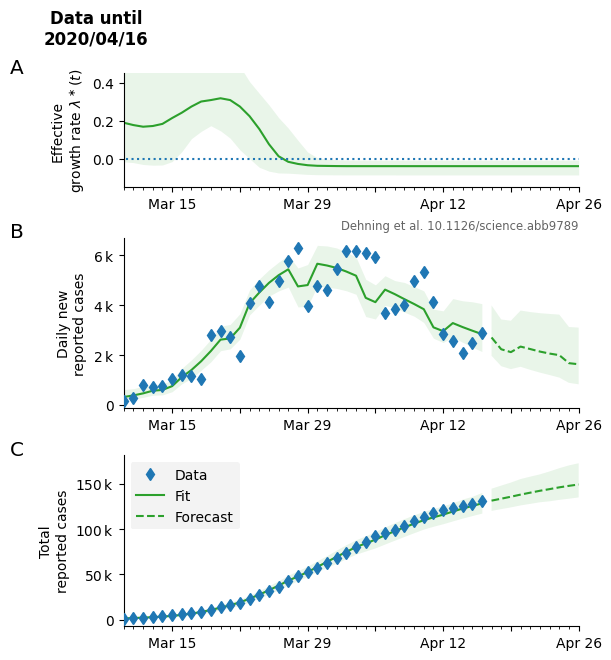

In [16]:
fig, axes = cov19.plot.timeseries_overview(this_model, idata, offset=total_cases_obs[0])

In [17]:
%load_ext watermark
%watermark  -iv

numpy            : 1.23.5
matplotlib       : 3.7.1
sys              : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
covid19_inference: 0.5.0
pytensor         : 2.14.2
pymc             : 5.7.2



# MSE
Berechne den Mean Squared Error für die beobachteten und vorausgesagten Fälle.

In [18]:
# Stelle sicher, dass beide Arrays die gleiche Länge haben
min_length = min(new_cases_obs.shape[0], idata.posterior["new_cases"].shape[2])
new_cases_obs = new_cases_obs[:min_length]
predicted_cases = idata.posterior["new_cases"][:, :, :min_length]
print("Länge der beobachteten Fälle:", len(new_cases_obs))
print("Länge der vorhergesagten Fälle:", predicted_cases.shape[2])
variance_observed = new_cases_obs.var()
print(variance_observed)

# Berechne die quadratischen Fehler
squared_errors = (new_cases_obs - predicted_cases.shape[2])**2

# Berechne den Durchschnitt der quadratischen Fehler (MSE)
mse = squared_errors.mean()
nmse = mse / variance_observed

print("Mean Squared Error:", mse)
print("Normalized Mean Squared Error:", nmse)

Länge der beobachteten Fälle: 38
Länge der vorhergesagten Fälle: 38
3597346.1827880507
Mean Squared Error: 14825372.868421054
Normalized Mean Squared Error: 4.121197158993174
